# Portfolio Hedging with Put Options

There are 2 good reasons to buy put options:

- Because you think they are cheap
- Because you want downside protection. You want to use the skewed payoff profile to protect a portfolio against large downside moves without capping your upside too much.

The first requires a pricing model. Or, at the least, an understanding of when and under what conditions options tend to be cheap.

The second doesn’t necessarily. We’ll assume that we’re going to have to pay a premium to protect our portfolio – and that not losing a large amount of money is more important than the exact price we pay for it.

Let’s run through an example.

We have a portfolio comprised entirely of 100 shares of SPY. About $56k worth.

We can plot a payoff profile for our whole portfolio. This is going to show the dollar P&L from our portfolio at various SPY prices.

At the time of writing, SPY closed at $564.86.

In the code below, I'm sourcing a script called `yahoo_prices.R`, which retrives prices from Yahoo Finance. You can find the code [here](https://robotwealth.com/yahoo-prices-r-easy/).

In [1]:
# load libraries
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, slider)

# set chart options
options(repr.plot.width = 14, repr.plot.height = 7, warn = -1)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# functions for getting data (see https://robotwealth.com/yahoo-prices-r-easy/)
source("../data_tools/yahoo_prices.R")

Loading required package: pacman



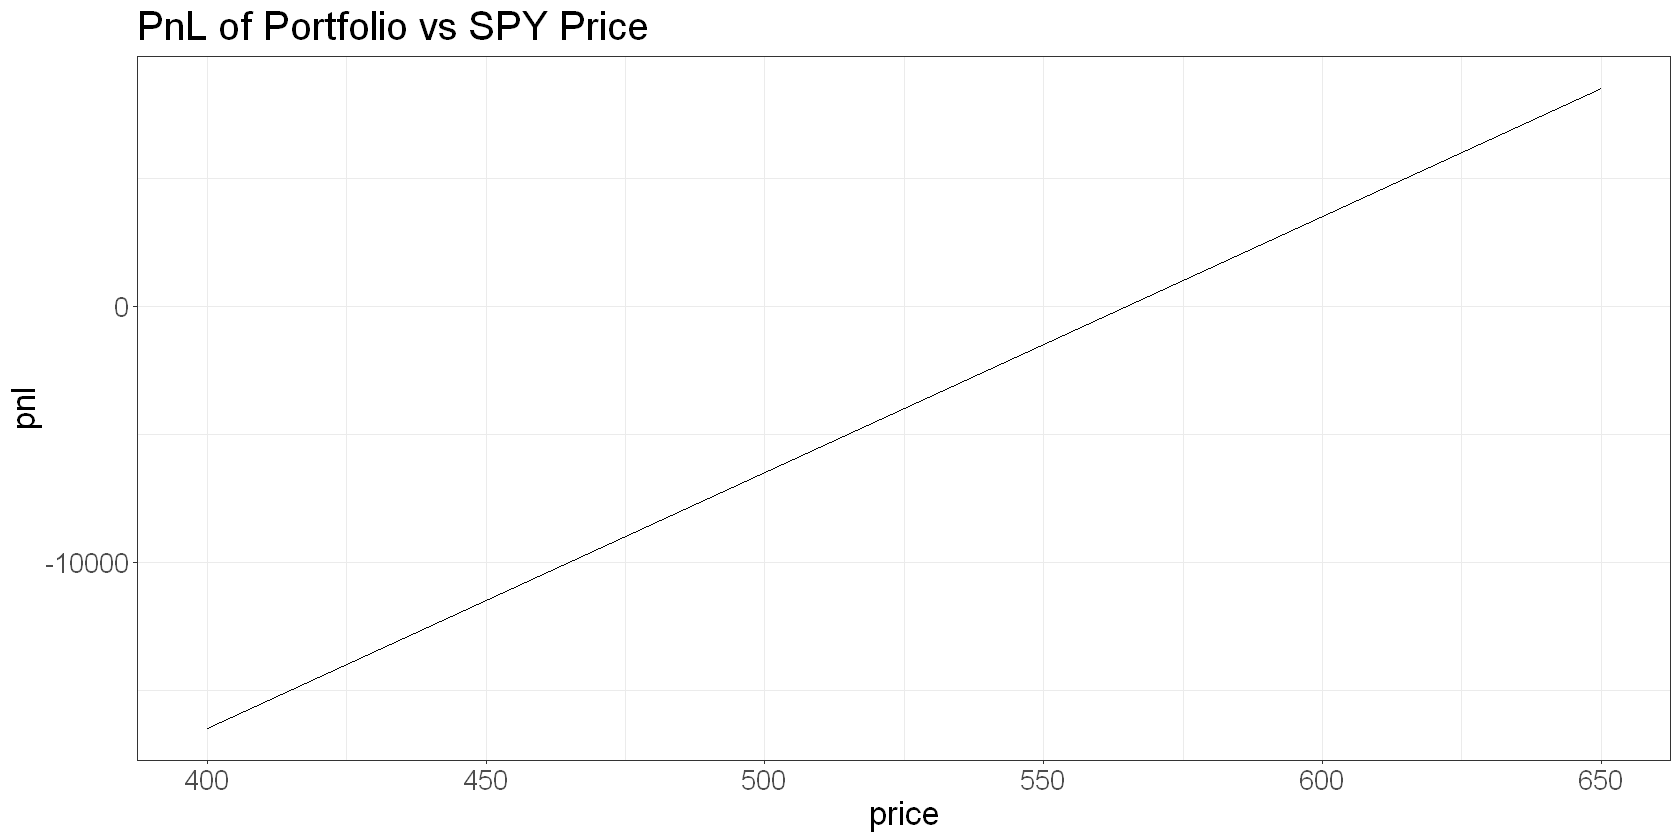

In [2]:
SPYprice <- 564.86
SPYshares <- 100
min_price <- 400
max_price <- 650

portfolio_payoffs <- tibble(price = c(min_price, max_price)) %>%
  mutate(pnl = (price - SPYprice) * SPYshares) 

portfolio_payoffs %>%
  ggplot(aes(x = price, y = pnl)) + 
  geom_line() + 
  ggtitle('PnL of Portfolio vs SPY Price')

So far, so unremarkable.

Now let’s say we want to limit our downside to no more than $10,000 (from current levels) over the next 3 months. That’s about a 17% decline.

First, we look at the SPY price which results in a $10,000 loss. From eyeballing the chart, that’s about $460. Let’s do it properly:

In [3]:
minlossprice <- SPYprice -10000 / SPYshares
minlossprice

[1] 464.86

Next, remember that a SPY put option struck at $465 gives us the option to sell 100 SPY shares at $465, regardless of the price of SPY.

If we buy an 18 October $465 SPY put, then we have capped our minimum possible portfolio loss to roughly -$10,000.

If we take the last traded price for that option then that "insurance" costs us about $1.06 per share, for $106 in total premium.

So for $106 (which is about 0.2% of our portfolio), we can "insure' our portfolio so it doesn’t drop any more than -$10,000 from current prices.

In this case, our insurance is very cheap because of the currently low volatility of SPY.

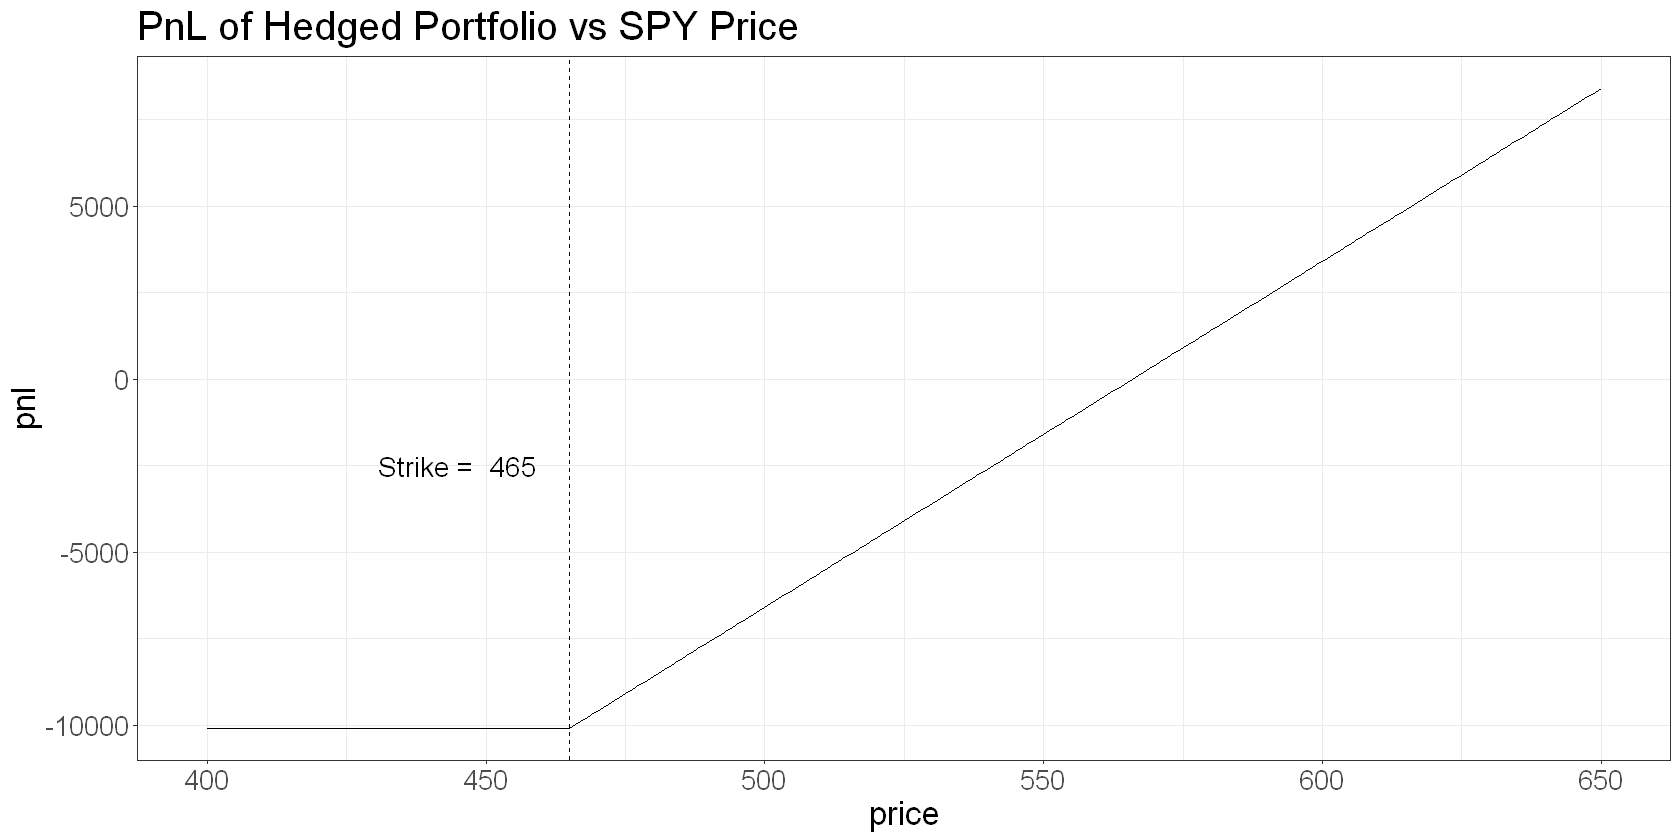

In [4]:
strike <- 465
premium <- 1.06

portfolio_payoffs_hedged <- tibble(price = c(min_price:max_price)) %>%
  mutate(pnl = case_when(
    price < strike ~ (strike - SPYprice - premium)*SPYshares,
    TRUE ~ (price - SPYprice - premium)*SPYshares
    ))


portfolio_payoffs_hedged %>%
  ggplot(aes(x = price, y = pnl)) + 
  geom_line() + 
  geom_vline(xintercept = strike, linetype = 'dashed') +
  annotate(geom = 'text', label = paste('Strike = ', strike), x = strike-20, y = -2500, size = 6) +
  ggtitle('PnL of Hedged Portfolio vs SPY Price')

Whether this is valuable to you depends on what you’re trading and what your risk tolerance is. More on this at the end of the post.

## But I don’t have a portfolio of just SPY!

Ok, so it’s highly unlikely that your portfolio is made up entirely of SPY. So here’s an example of hedging a degenerate portfolio of small caps using SPY puts.

First, get some price history for SPY and a few small caps:

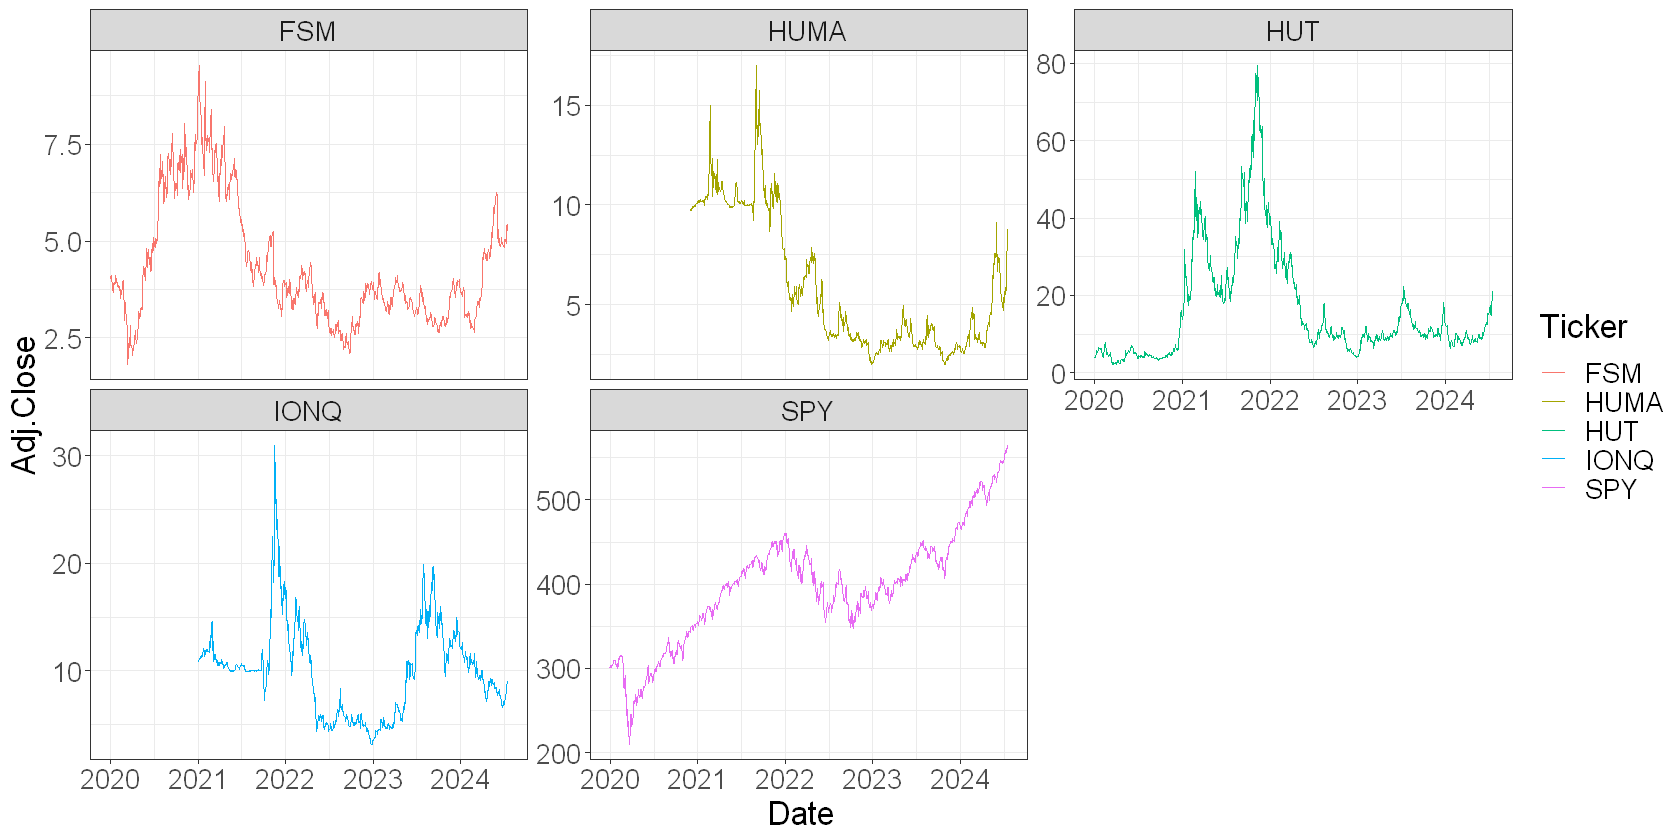

In [5]:
tickers <- c('HUMA', 'HUT', 'IONQ', 'FSM', 'SPY')

prices <- yahoo_prices(
  tickers,
  from_date = "2020-01-01", to_date = "2024-07-17"
)

prices <- prices %>%
  group_by(Ticker) %>%
  mutate(returns = Adj.Close / lag(Adj.Close) - 1)

prices %>%
  ggplot(aes(x = Date, y = Adj.Close, colour = Ticker)) +
    geom_line() +
    facet_wrap(~Ticker, scales = "free_y")

Next, calculate our portfolio’s beta to SPY. We’ll assume we’re invested equal weight in these stocks.

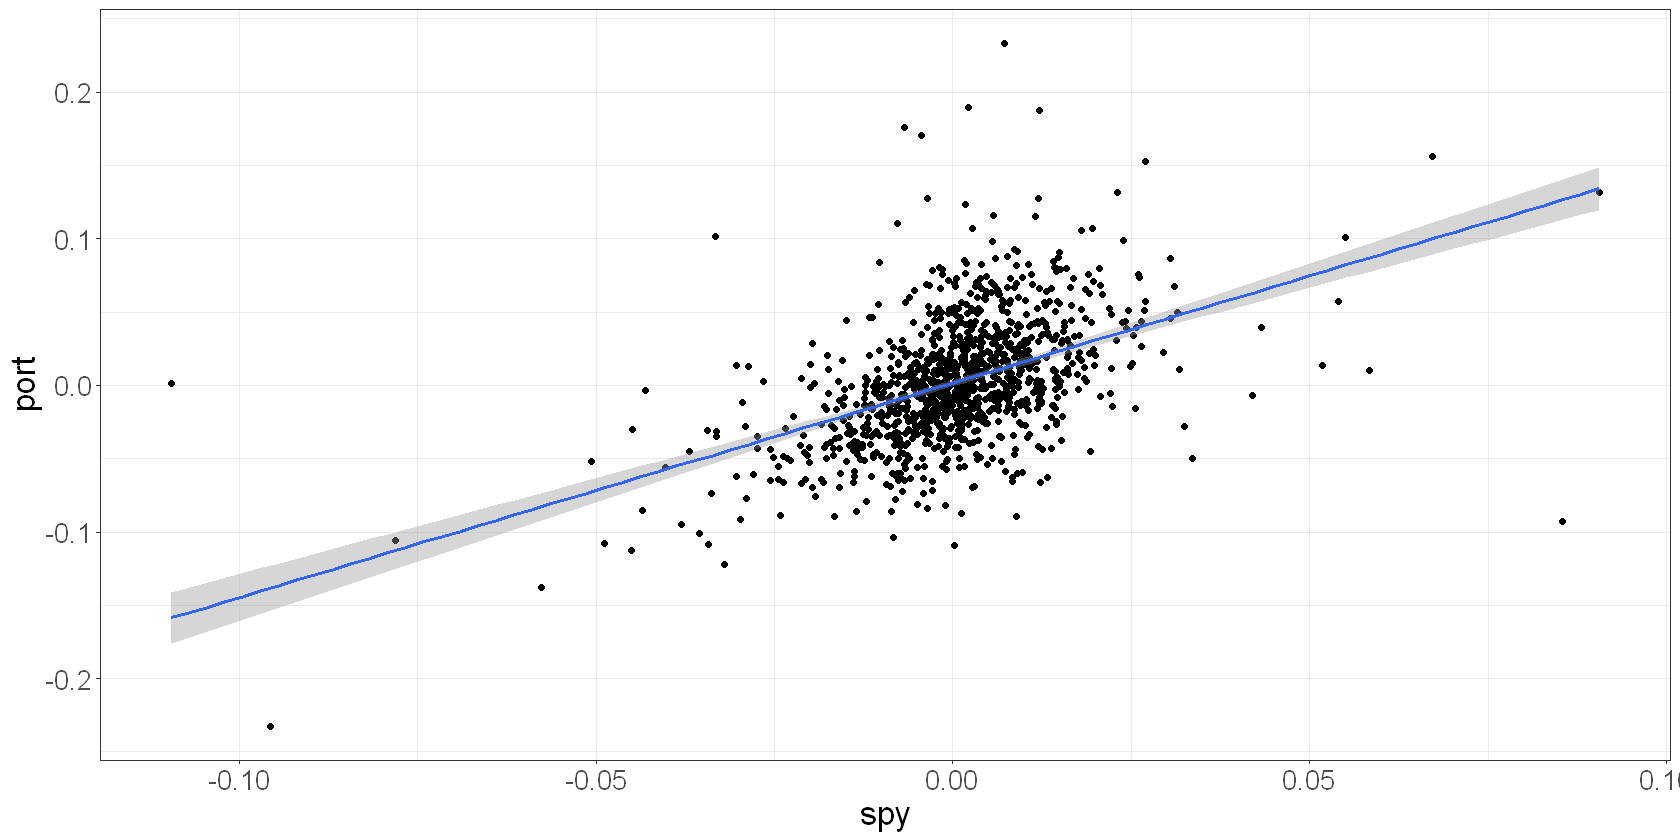

In [6]:
portfolio_returns <- prices %>%
  filter(Ticker != 'SPY') %>%
  group_by(Date) %>%
  summarise(port = mean(returns)) %>%
  left_join(
    prices %>% filter(Ticker == 'SPY') %>% select(Ticker, Date, returns),
    by = 'Date'
  ) %>%
  select(Date, port, returns) %>%
  rename('spy' = returns)

portfolio_returns %>%
  ggplot(aes(x = spy, y = port)) +
    geom_point() +
    geom_smooth(method = lm, formula = y ~ x)

Estimate a 100-day rolling beta of our porfolio to SPY:

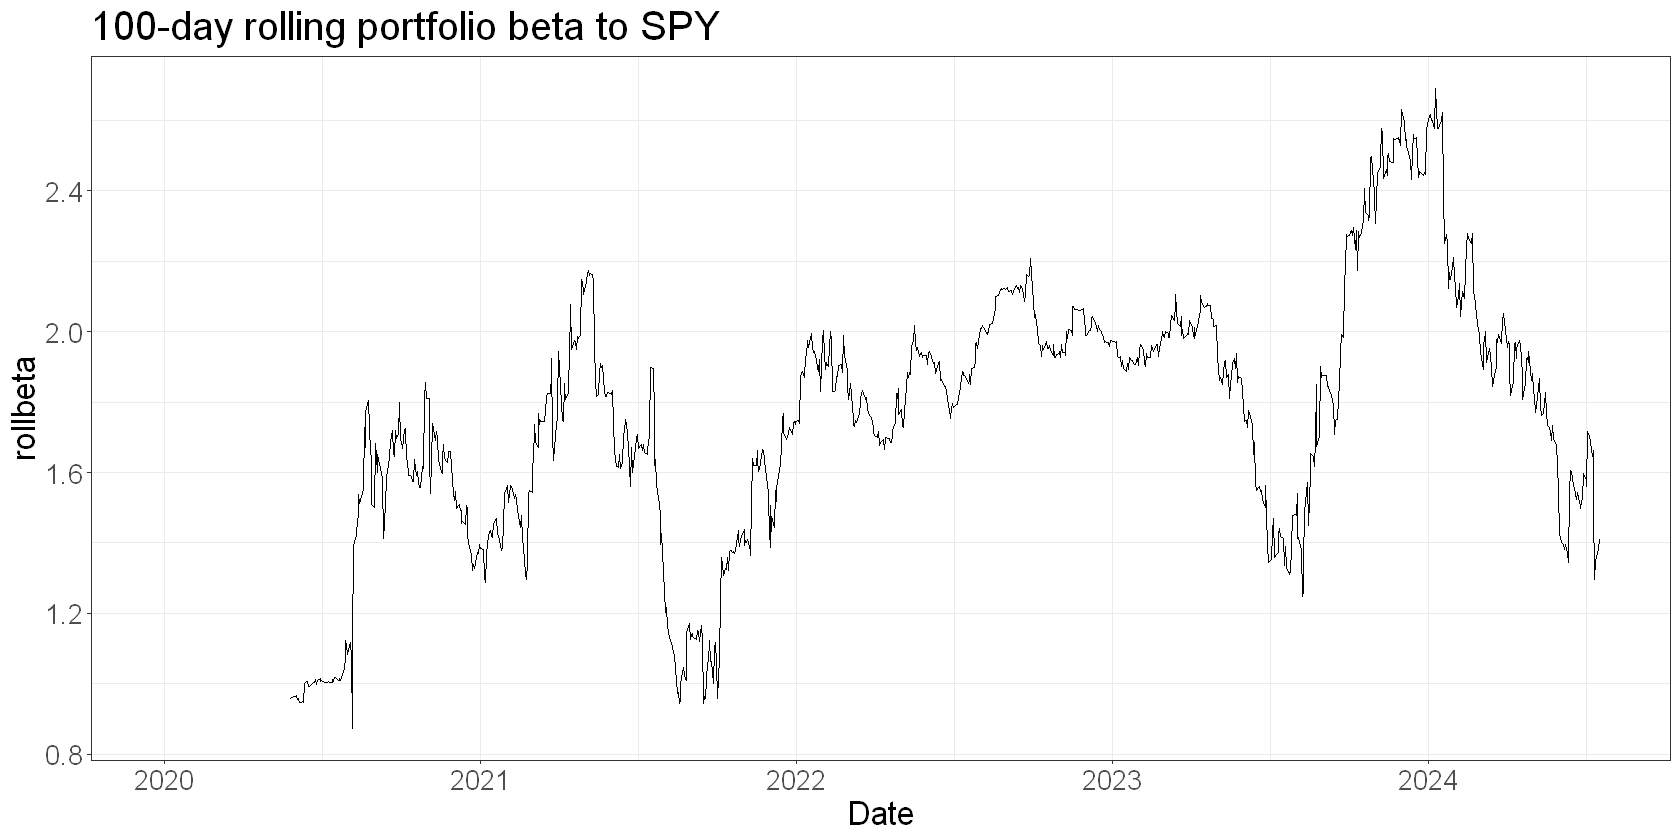

In [7]:
get_beta <- function(x) {
  mod <- lm(port ~ spy, data = x)
  return(mod$coefficients['spy'])

}

portfolio_returns <- portfolio_returns %>%
  mutate(rollbeta = slide_dbl(., ~get_beta(.x), .before = 100, .complete = TRUE))

portfolio_returns %>%
  ggplot(aes(x = Date, y = rollbeta)) +
  geom_line() +
  labs(title = "100-day rolling portfolio beta to SPY")

Let’s take our portfolio beta at the current 100-day rolling estimate. You can see that the estimate is rather noisy – this won’t be too precise.

In [8]:
port_beta <- portfolio_returns %>%
  select(rollbeta) %>%
  last() %>%
  pull()

round(port_beta, 2)

[1] 1.41

Our portfolio beta is about 1.41.

That means that for every dollar invested in our portfolio, we would need to hedge 1.41 dollars worth of SPY.

Let’s say our portfolio is worth $100,000. That means we need to hedge $141,000 of SPY. Given the current SPY price, we would need the following quantity of shares of SPY:

In [9]:
port_value <- 100000
SPYprice <- 565

shares_of_spy <- port_value*port_beta/SPYprice
round(shares_of_spy, 0)

[1] 249

Now, we can only hedge to the nearest 100 shares of SPY (told you this can’t get too precise). So, in this case, we’d buy two SPY puts and call ourselves slightly under-hedged. You could on the other hand by 3 puts and find yourself slightly over-hedged.

*What's the optimal thing to do?*

Well, everything is a trade-off. Being under-hedged costs less in the premium you pay, but leaves you, well, under-hedged. Being over-hedged costs you more in premium, but leaves you more than adequately protected.

Portfolio hedging with index put options, in reality, requires a juggling of basis risk (you can only hedge in 100 share units) and correlation risk – where correlation risk is the risk of hedging on the basis of the betas of the components of your portfolio.

## So should I hedge my portfolio with index put options?

That depends on:

- Your trading edge
- What risk you’re taking in the portfolio
- What your risk tolerance is

If you’re running a highly leveraged portfolio of negatively skewed carry-trades, for example, then there is a time in the future when you will lose a large amount of money very quickly.

Losing a lot of money is bad. And making sure you don’t lose a lot of money is more important than the exact price you pay for that insurance. So provided you do indeed have a large edge, I would very likely pay up for crash protection in this scenario.

However, this assumes you have a significant trading edge. Portfolio insurance is costly, so you need to be confident that you have a large edge which is significantly greater than the cost you’re going to pay to hedge your downside.

If you aren’t confident in your trading edge, then you would be much better, in my opinion, sizing your trading down to a point where you are happy taking on the downside risk.

## Summary

In this post, we’ve been through a very simple approach to hedging a simple portfolio of equity-like assets. It’s an approach that doesn’t require an options pricing model, just an appreciation of how much you are willing to pay for downside protection given a realistic assessment of your trading edge.